<div style="background-color:#342184; padding:6px; color:#f3f0ff;">

# Try Finesse 3

</div>

In this interactive notebook we introduce <a href=http://www.gwoptics.org/finesse/>Finesse 3</a>. We are using the <a href="https://www.python.org/">Python</a> programming language, executed in <a href="http://jupyter.org/">Jupyter</a> notebooks. Even if you are not familiar with Python we expect that you will be able to play around with the provided examples.

You can experiment with the live code presented here, create your own notebook (`File > New Notebook`), or upload a notebook you wish to test-run. Note that **changes are not saved after exiting the Binder/Colab session**, so you should download a local copy of any notebooks you wish to retain. (This notebook requires the following image files nodal_network.svg, model_sketch.svg, fabry-perot02.svg, michelson_with_nodes.svg).

We introduce the interferometer modelling software Finesse which was developed for the design and commissioning of laser-interferometric gravitational wave detectors. It is optimised for modelling the main interferometers of LIGO, Virgo, Einstein Telescope etc, but it is also a simple and versatile tool to learn basic laser optics. 

See below, at the end of the notebook, for links to more information about Python, Jupyter and Finesse.

### In this notebook

Finesse numerically models optical systems in the _frequency domain_. This notebook demonstrates simple tasks: modelling the amount of light transmitted or reflected by a single beamsplitter or by a 2-mirror optical cavity. You can learn more about 2-mirror cavities, also known as Fabry-Perot  cavities or interferometers, by reading <a href=https://link.springer.com/article/10.1007/s41114-016-0002-8#Sec33>section 5.1</a> of Interferometer Techniques for Gravitational-Wave Detection and the handouts and references we have provided.

You may wish to open the <a href="https://finesse.ifosim.org/docs/latest/">Finesse 3 documentation</a> in another tab to look up the Finesse syntax. 

# Getting started

First we import Finesse and some other Python packages into the notebook.

(type shift+enter to execute commands and the cells)


In [20]:
# install pypi wheel only on google colab
!env | grep -q 'colab' && pip install finesse || echo 'Not on google colab, assuming finesse already installed'

Not on google colab, assuming finesse already installed


In [21]:
import matplotlib.pyplot as plt
import finesse
from finesse.analysis.actions import Xaxis
finesse.init_plotting()

# Setting up a model and running a simulation

### Model = a network of components

In the most simple case, we can think of the model as a set of **optical components** connected to each other via **nodes**. The nodes are virtual connection points between the components and are accessed via **ports**, e.g., optical ports contain two nodes, an input node (`component.p1.i`) and an output node (`component.p1.o`). They have unique names and store which components they are connected to. This allows for the analysis of the interferometer structure by traversing the list of existing nodes. Such a system is also called a **nodal network**. For example, a system of two mirrors separated by a distance would be modelled as three components (mirror, space, mirror). The mirrors have two optical ports, each with an input node and and output node:

<div style="background-color:white; padding: 1em; text-align:center"><img src="nodal_network.svg" width=70% /></div>

Nodes are accessed using dot (`.`) notation starting with the component name, e.g., the input node `i` in the `p1` optical port of the second mirror can be accessed with `m2.p1.i`.

The 'space' is also an optical component because the free propagation changes the phase of the light beam, and anything that changes a property of the light field is treated as a component by definition. A space connects two components via optical ports, e.g., the space above connects the two mirrors with `s s1 mirror1.p2 mirror2.p1`.

### Simulation = making a plot

Many simulation tasks can be thought of as making a plot: we look at an interferometer output signal when varying an interferometer parameter, e.g., a mirror position. An interferometer can have many output signals, most of which are the signals of photodetectors. Thus, in Finesse 3, a typical simulation task is defined by:
  1. creating the optical model by specifying the components
  2. adding the desired detectors to create output signals
  3. varying a parameter (using the `Xaxis` action)

# A First Model

Let's construct a simple Finesse model of a laser beam shining on a beamsplitter. In this simulation, we'll just vary the input laser power and see how much light is transmitted through the beamsplitter. To measure the laser power, we connect a photodiode to the correct node at the beamsplitter.

The sketch below shows a sketch the setup and also a diagram of the equivalent nodal network:

<div style="background-color:white; padding:1em; text-align:center;">
<img src="model_sketch.svg" width="60%" />
</div>

## 1) Creating the optical model

We'll start by creating the optical model by specifying the components. The Finesse 3 code for this setup looks as follows:

In [22]:
# create a new Finesse model object,
# this serves as the foundation of the simulation, so we'll name it `base`
base = finesse.Model()

# setup of the interferometer, each line is one component
code = """
l laser1 P=1                # laser with P = 1W at the default frequency
s s1 laser1.p1 bs1.p1 L=1   # 1m space connecting the laser to the beamsplitter
bs bs1 R=0.5 T=0.5          # 50:50 beam splitter
"""

# parsing the setup description to generate the model
base.parse(code)

## 2) Adding detectors

We can then decide the output we would like to produce by adding detectors. We'll want to first produce a copy (via the "deepcopy" method) of the base model so it can be reused for other simulations.

In [23]:
# copy the base model
ifo1 = base.deepcopy()

# adding a photodiode detecting the transmitted light
ifo1.parse("pd pow_t bs1.p3.o")

## 3) Varying a parameter

In Finesse 3, we can vary a parameter using the `Xaxis` action. This action will run the simulation for a range of parameter values and return a `Solution` object. Actions are executed using the model's `run()` method.

For this simulation, we will vary the laser power (`laser1.P`) linearly from 0 Watts to 1 Watt in 100 steps to see what the detector produces:

In [24]:
# Run the simulation and change the laser power from 0 to 1W in 10 steps
out1 = ifo1.run(Xaxis('laser1.P', 'lin', 0, 1, 10))

The output data can be plotted in multiple ways. If you want to see the results quickly we suggest using the built-in `plot()` function:

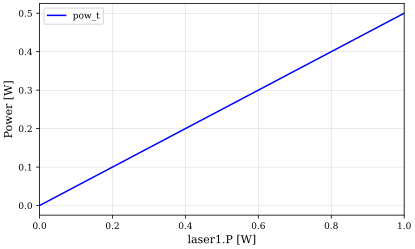

In [25]:
# plotting the results of an output can be done using the built-in command
fig = out1.plot()

This will produce a plot using all the detectors enabled in the model.

However, if you would rather make a plot yourself you can always just use `matplotlib` commands as per usual:

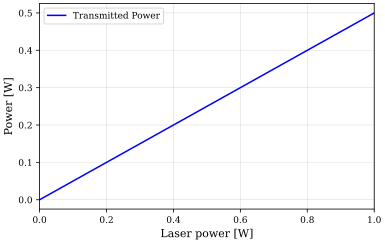

In [26]:
fig = plt.figure()
plt.plot(out1.x1, out1["pow_t"], label="Transmitted Power")
plt.xlim(out1.x1.min(), out1.x1.max())
plt.ylabel("Power [W]")
plt.xlabel("Laser power [W]")
plt.legend()
plt.show()

The `Solution` object returned by running the `Xaxis` action is important as it contains all the results from the simulation as an array of numbers: the steps in the simulation are accessed as an array via `out.x1` and each detector can be accessed by name, e.g., `out['pow_t']`.

You can see the raw outputs with:

In [27]:
print(out1.x1) # show the xaxis values
print(out1['pow_t']) # show the detector values
print(out1.detectors) # show the available detectors

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]
('pow_t',)


# Tasks
The rest of the notebook provides some example code as tasks. We recommend that you make a copy of the notebook, delete the code and try to solve the tasks by recreating the code yourself.

## Task 1: Check for power conservation

Do the following:
  1. Copy the previous model with `ifo2 = base.deepcopy()`, this allows for edits without changing the original.
  2. Add two photodetectors `pow_t` and `pow_r` to the new `ifo2` model to measure the transmitted and reflected light.
  3. Run this model with `ifo2.run()` to get the simulation output.
  4. Check if the reflected and transmitted power match up with the input power.

In [28]:
ifo2 = base.deepcopy()

ifo2.parse("""
pd pow_t bs1.p3.o
pd pow_r bs1.p2.o
""")

out2 = ifo2.run()
print(f"{out2['pow_t']+ out2['pow_r']:.2}")

1.0


# Modeling Optical Cavities in FINESSE

Now we will model a simple Fabry-Perot (FP) cavity. The optical layout of a FP cavity is shown in the figure below. Lets see how we can model the setup in FINESSE. The geometry of these cavities is inspired by the Advanced LIGO arm cavities. (Source: https://finesse.docs.ligo.org/finesse-ligo/parameter_files/llo.html).

<div style="background-color:white; padding:1em; text-align:center;">
<img src="FP.png" width="60%" />
</div>

### Defining the optical layout of the cavity

In [29]:
## Modeling a FP-cavity in FINESSE
## ----------------------------------------------------

cavLIGO = finesse.Model()

## STEP 1
# Defining the optics (lasers, mirrors, etc.)
cavLIGO.parse(
f"""
# Input optics          
l l1 P=1 #laser with 1W power
s s1 l1.p1 ITM.p1 L=0 #space between laser and input test mass

# Input test mass/mirror of the cavity
# T and L are the transmittivity and losses in the mirror
# and R (reflectivity) is computed as R=1-T-L. 
m ITM T=0.0148 L=37.5e-6 Rc=-1937.9 #mirror component
           
# Space between the two test masses 
s s2 ITM.p2 ETM.p1 L=3994.485 # length between the two mirrors

# End test mass 
m ETM T=7.1e-6 L=37.5e-6 Rc=2240.0 #mirror
""");

So how do we define the geometry of the mirrors and our system? Using the attributes. So each component has attributes with which it is defined. That's how FINESSE knows what the "Physics" should be. One can easily access these attributes in the following way.

In [30]:
copyLIGO = cavLIGO.deepcopy()

print(copyLIGO.ETM.T) #end test mass
print(copyLIGO.s1.L) #length

# you can also print all the attributes and check them
print(copyLIGO.ETM)

7.1e-06
0.0 m
Mirror('ETM', misaligned=False, ybeta=0.0, xbeta=0.0, Rcy=2240.0, Rcx=2240.0, phi=0.0, L=3.75e-05, T=7.1e-06, R=(1-(ETM.T+ETM.L)))


You can also change these attributes by simply giving it a new value. 

In [31]:
copyLIGO.s2.L = 4000
print(copyLIGO.s2.L)

# The distance between the two mirrors have now changed

4000.0 m


You can also easily see the connections and various detectors of your model using the *component_tree* in FINESSE.

In [32]:
print(copyLIGO.component_tree())

○ l1
╰──○ ITM
   ╰──○ ETM


### Add detectors to your model.

Its important to know what you want to measure and where in your model. 

In [33]:
det = cavLIGO.deepcopy() 

# adding detectors to our model to probe different Physics
det.parse(
    f"""
    # power detectors to measure the total power
    # circulating, transmitted, and reflected. 
    pd refl ITM.p1.o 
    pd trans ETM.p2.o
    pd circ ETM.p1.i
"""
)

The detectors are added to the nodes of the components. Depending on where you want to measure you will decide the right port. For example, if you would like to measure the reflection of the cavity, where do you think you will place your detector? **ITM.p1.o**. 

There is a whole class of detectors in FINESSE, ranging from CCD cameras, to power detectors: <a href=https://finesse.ifosim.org/docs/latest/usage/elements/detectors.html#detectors/>FINESSE detectors</a>. 

In [34]:
print(det.component_tree(show_detectors=True, show_ports=True))

○ l1
╰──○ ITM (l1.p1 ↔ ITM.p1)
   ├──○ ETM (ITM.p2 ↔ ETM.p1)
   │  ├──○ circ (ETM.p1.i)
   │  ╰──○ trans (ETM.p2.o)
   ╰──○ refl (ITM.p1.o)


## Perform SIMULATIONS. 

This is where we change some model parameters systematically and study the Physics of our optical system that we have modeled using the detectors. 

For the purpose of this task we will perform what we call the Free Spectral Range scans (FSR). These scans represent the nature of the cavity and its reponse i.e. how the laser light behaves or interacts with the cavities. The FSR scans are performed by scannig over the tuning (**.phi**) parameter or the mircoscopic length of the mirrors.

In [35]:
sim = det.deepcopy()

# FSR scans of the LIGO cavities
scans = sim.run(Xaxis('ETM.phi', 'lin', -200, 200, 500))

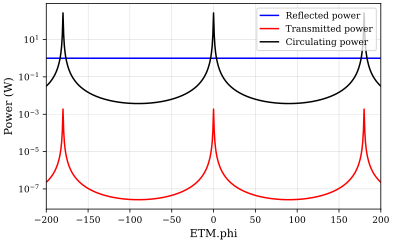

In [36]:
# Plots
plt.plot(scans.x[0], scans['refl'], label="Reflected power")
plt.plot(scans.x[0], scans['trans'], label="Transmitted power")
plt.plot(scans.x[0], scans['circ'], label="Circulating power")
plt.yscale('log')
plt.legend()
plt.xlabel('ETM.phi')
plt.ylabel("Power (W)")
plt.show()

## Optional: Defining the beam inside the cavity

# Additional Info

## References for Python, Jupyter, and Finesse 3

*Info and reference material for Finesse 3*:
  * <a href="https://finesse.ifosim.org/docs/latest/">Finesse 3 documentation</a>
  * <a href="https://gitlab.com/ifosim/finesse/finesse3">Finesse 3 source code</a>

*Info and reference material for Finesse 2* (note that Finesse 2 uses a different syntax):
  * <a href="http://www.gwoptics.org/finesse">Finesse 2 main page</a>
  * <a href="http://www.gwoptics.org/finesse/reference/">Finesse 2 online syntax reference</a>
  * <a href="http://kvasir.sr.bham.ac.uk/redmine/attachments/download/131/Finesse_2.0_manual.pdf">Finesse 2 manual</a> (>200 pages pdf file)
  * <a href="http://www.gwoptics.org/learn/">Learn Laser Interferometry</a>, our online collection of notebooks such as this one
  * <a href='http://www.gwoptics.org/learn/01_Introduction/01_Getting_Started/03_Pykat.html'>reference notebook for Pykat</a>
  
*Some info and reference material on Python and Jupyter*:
  <!-- removed because only for Python 2.7 -->
  <!-- * A <a href="http://nbviewer.ipython.org/gist/rpmuller/5920182">Crash Course in Python for Scientists</a> -->
  * The <a href="https://docs.python.org/3/tutorial/index.html">Python tutorial</a> and a <a href="https://numpy.org/doc/stable/user/absolute_beginners.html">Numpy tutorial</a>
  * The <a href="https://jupyter.org/">Jupyter project page</a>
  * The text cells in this notebook are fomatted using <a href="https://daringfireball.net/projects/markdown/syntax">Markdown</a>
